 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** : In progress
 
**Purpose**: We propose here an assimilation problem coupled with Solver DL (deep learning), the goal is to infer the mass **m** and the moment of inertia **$I_\alpha$** of a PAPA from observations made on the displacements.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (13 Juin 2022)

-----------------------------------

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
from tabulate import tabulate

# ------ Importation Local
# utils for Post-Trait ( plot, ..)
sys.path.append("../")
from Post_Trait import POSTRAIT, All_Data_Set
Path_src     = "../../"
#--- DATA : output of DA code

#--- Config 
PATH_CONF = Path_src+"Inference_Problem/CAEL/" 
sys.path.append(PATH_CONF)





In [35]:
PST_dic = {}
List_color =  ["black","grey", "blue", "red",  "green","cyan", "orange","purple", "pink"]
k=0
## ----------------------------- :
Path_res       = "CAEL/AmpFreq/"
PATH_DATA      = Path_src+"DATA_09012023/DA_4DEnVar_V2/"+Path_res
label          = "EnVar"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
k+=1


# ### ----------------------------- :
Path_res       = "CAEL_FNN/AmpFreq/"
PATH_DATA      = Path_src+"DATA_09012023/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color, Path_Src= Path_src)
k+=1

## ----------------------------- :
Path_res       = "CAEL_SWAG_V0/AmpFreq/"
PATH_DATA      = Path_src+"DATA_09012023/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG-V0"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color, Path_Src= Path_src)
k+=1

# ### ----------------------------- :
Path_res       = "CAEL_SWAG_V1/AmpFreq/"
PATH_DATA      = Path_src+"DATA_09012023/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG-V1"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color, Path_Src= Path_src)
k+=1

# # ### ----------------------------- :
Path_res       = "CAEL_SWAG_V2/AmpFreq/"
PATH_DATA      = Path_src+"DATA_09012023/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG-V2"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color, Path_Src= Path_src)
k+=1


In [36]:
PST_dic[label].show_cfg()

-------------------------------------------------------------------------------------------------------------------
                                                Parametres                                         
--------------------------------------------------------------------------------------------------------------------
     Modele name      :                   CAEL                
     DA Method        :                   4DEnVar (V2)        
     Uncertains param :                                                       
                  name     : pitch_amp   pitch_frq
                 reference : pitch_amp = 2.51   pitch_frq = 62.5   
                 estimate  : pitch_amp = 3.5   pitch_frq = 75   
                                                                         
     Nbr Iteration =  20  |  Nbr Ensemble =   40  | Param_sigma = 0.300000
                                                                         
     Observations     :                                

### Control Vectors  

In [37]:
all_gamma = [PST_dic[label].CFG.Param_Ref, PST_dic[label].CFG.Param_Est]
index   = ["Reference","Initialisation"]

for key, PST in PST_dic.items() :
    all_gamma.append(PST.Param_Opti)
    index.append("Optimized {"+PST.label+"}")
    
df =pd.DataFrame(all_gamma, index = index,columns=PST_dic[label].CFG.Param_Name)    

print(tabulate(df, tablefmt='grid',headers='keys'))
print("")    

+------------------------------+-------------+-------------+
|                              |   pitch_amp |   pitch_frq |
+==============================+=============+=============+
| Reference                    |     2.51    |     62.5    |
+------------------------------+-------------+-------------+
| Initialisation               |     3.5     |     75      |
+------------------------------+-------------+-------------+
| Optimized {EnVar}            |     2.53407 |     62.5069 |
+------------------------------+-------------+-------------+
| Optimized {EnVar-DL}         |     2.9687  |     63.448  |
+------------------------------+-------------+-------------+
| Optimized {EnVar-DL-SWAG-V0} |     3.24797 |     74.1699 |
+------------------------------+-------------+-------------+
| Optimized {EnVar-DL-SWAG-V1} |     3.55418 |     67.4405 |
+------------------------------+-------------+-------------+
| Optimized {EnVar-DL-SWAG-V2} |     3.63436 |     63.9066 |
+-----------------------

### Function Cost  


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$



\begin{equation}
    J = \underbrace{\frac{1}{2} \Vert \Gama-\Gamae \Vert ^2 }_{J_b}+\underbrace{\frac{1}{2} \sum_{k=0}^{N} \Vert \boldsymbol{y}_k -\boldsymbol{h}(\boldsymbol{x}_k) \Vert^2}_{J_{obs}}
    \label{eq_J}
\end{equation}



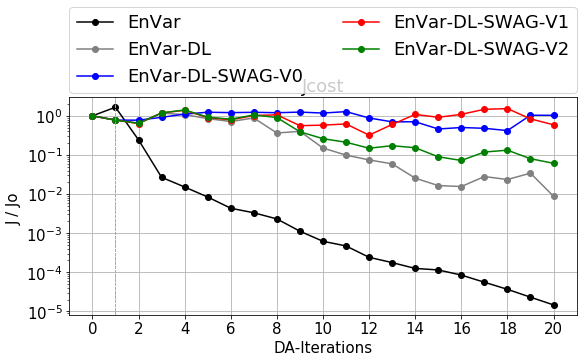

In [38]:
plt.figure(figsize=(20,4))
List_Jcost = ["Jcost"]
# List_Jcost = ["Jcost"]
k = 1
for k_cost, name_cost in enumerate(List_Jcost) :
    plt.subplot(1,2,k)
    for key, PST in PST_dic.items() :
        PST.plot_Jcost(linestyle='-o',k=k_cost)
        plt.title(name_cost, fontsize =18)
        if PST.CFG.Use_DL:
            plt.axvline(x=PST.i_start_ML,c="y",linestyle='--',lw =0.8)

    plt.grid(True)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                                mode="expand", borderaxespad=0, ncol=2,fontsize=18)
    if k % 2 == 0 and k!= len(List_Jcost):
        k = 1
        plt.show()
        plt.figure(figsize=(20,4))
        
    else :
        k+=1

plt.show()


##  Relative Error  

$$ e_r = \frac{\gamma_{opti} - \gamma_{ref} } {\gamma_{ref}} \times 100$$

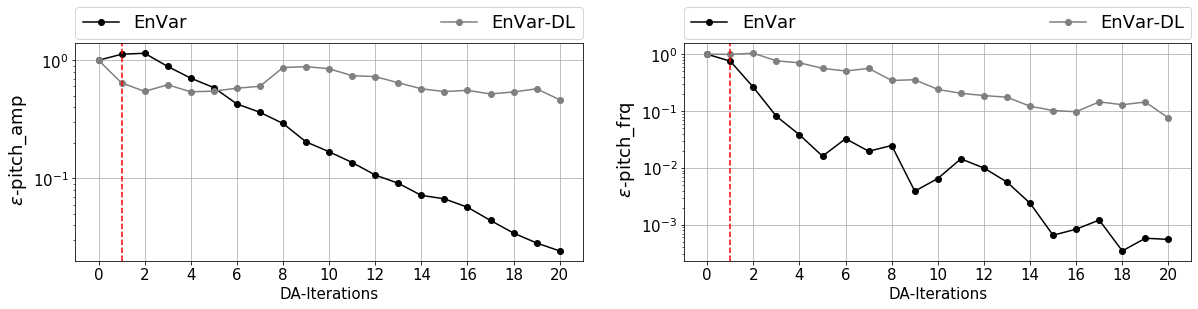

In [19]:
n_col = len(PST.CFG.Param_Name)
plt.figure(figsize=(20,4))

k=1
y_label =  "U_r"

for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    for key, PST in PST_dic.items() :
        
        N_iter  = [j for j in range(len(PST.Param_error))]
        plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c=PST.color,label = PST.label)

    new_list = range(math.floor(min(N_iter)), math.ceil(max(N_iter))+1,2)
    plt.xticks(new_list, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('DA-Iterations',fontsize=15)
    plt.ylabel(fr" $\epsilon$-{name}",fontsize=18)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=2,fontsize=18)    
    plt.grid()
    plt.axvline(x=PST.i_start_ML,label="Start DL coupled",c="r",linestyle='--')
    
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1


In [20]:
len(PST.time)

500

## Number of CFD calculations

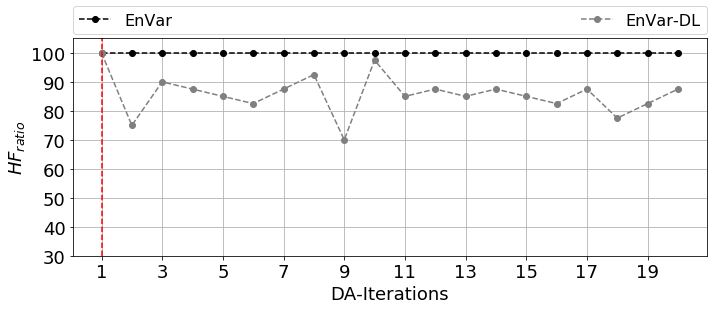

In [21]:
plt.figure(figsize=(25,4))
plt.subplot(1,2,2)
for key, PST in PST_dic.items() :
    PST.plot_HF_ratio(linestyle='--o')
    if PST.CFG.Use_DL:
        plt.axvline(x=PST.i_start_ML,c="r",linestyle='--')
    
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=2,fontsize=16)
plt.ylim(30,105)
plt.show()

## Reconstruction of Observables 

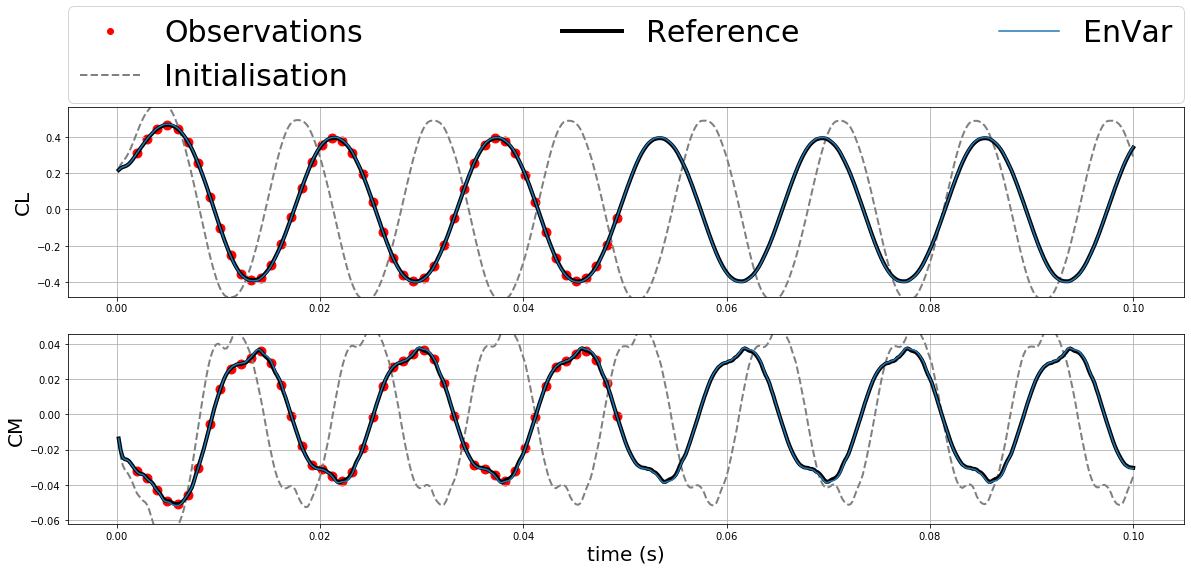

In [14]:
plt.figure(figsize=(20,200))
for i,name_obs in enumerate(PST_dic[label].CFG.Obs_Name) :
    plt.subplot(PST_dic[label].CFG.Number_Observation, 1 , i+1)
    plt.plot(PST_dic[label].time_obs, PST_dic[label].observations[:,i], 'o',color='r',label='Observations')
    plt.plot(PST_dic[label].time,PST_dic[label].observables_est[:,i],'--',color='grey',label='Initialisation' ,linewidth=2)
    plt.plot(PST_dic[label].time,PST_dic[label].observables_ref[:,i],'-',color='k',label='Reference',linewidth=4)
    k =0
    for key, PST in PST_dic.items():
        plt.plot(PST.time,PST.observables_opti[:,i],label=PST.label )
    plt.scatter(PST_dic[label].time_obs, PST_dic[label].observations[:,i], marker='o',color='r',s=80)
    v_min = np.min(PST_dic[label].observables_opti[:,i]) ; v_min=v_min - (v_min/abs(v_min))*v_min*0.2
    v_max = np.max(PST_dic[label].observables_opti[:,i]) ; v_max=v_max + (v_max/abs(v_max))*v_max*0.2 
    plt.ylabel(name_obs,fontsize=20)
    plt.ylim([v_min,v_max])
    plt.grid()
    if   i== 0:
        plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=3,fontsize=30)
plt.xlabel('time (s)',fontsize=20)
plt.show()

## Training of the FNN model


----------------- For : EnVar-DL-SWAG-V2 ------------



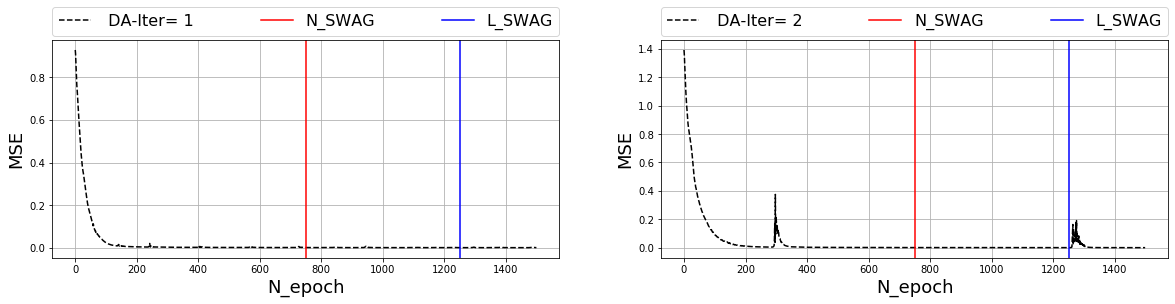

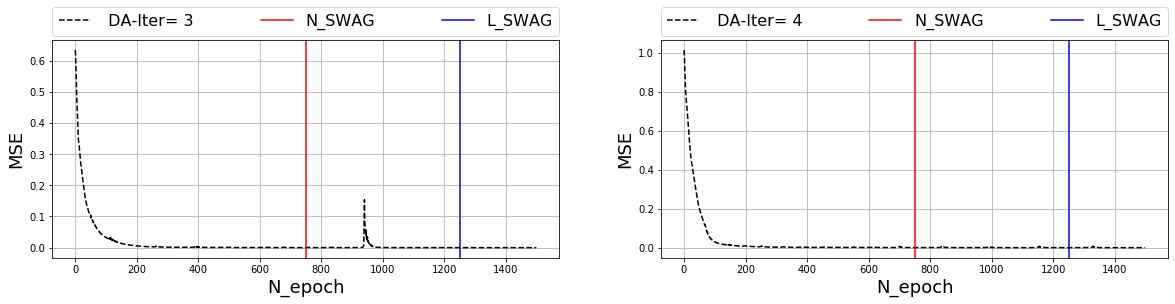

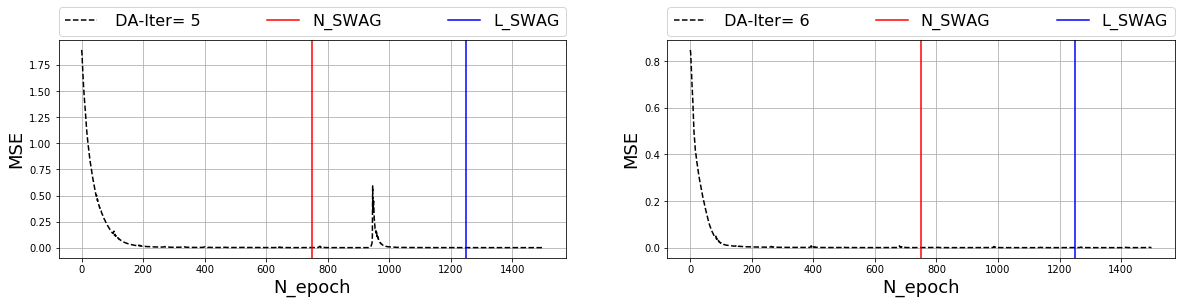

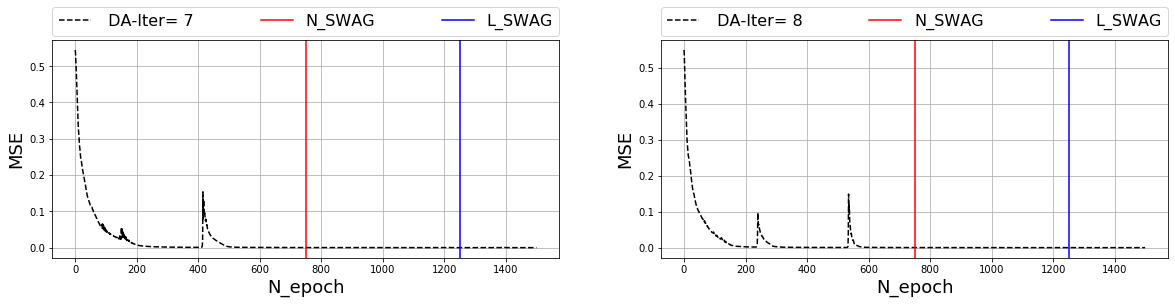

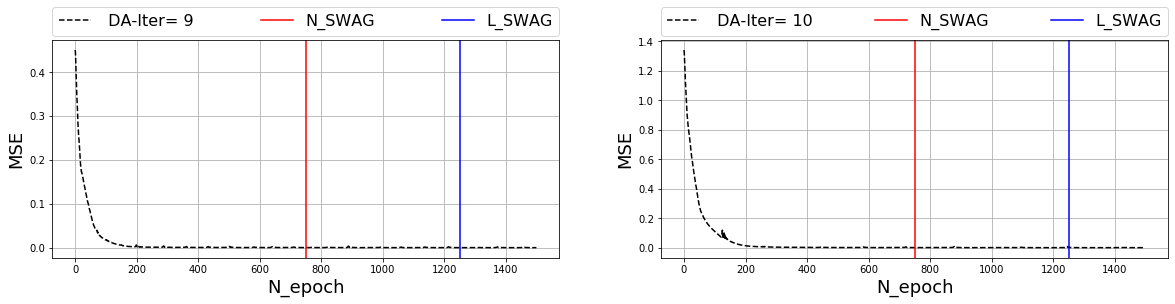

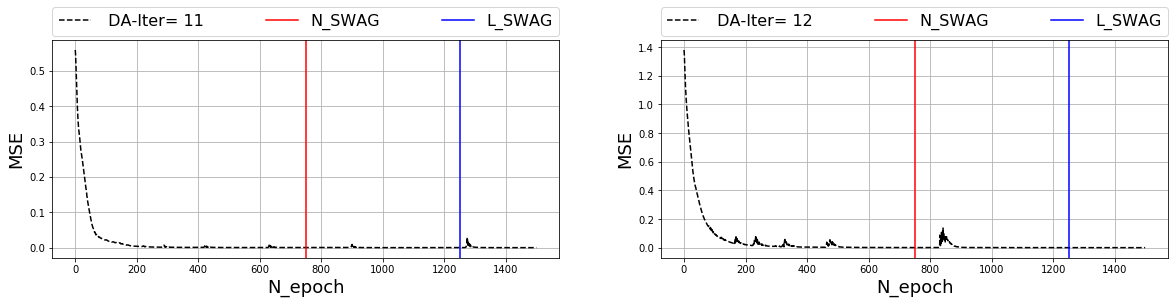

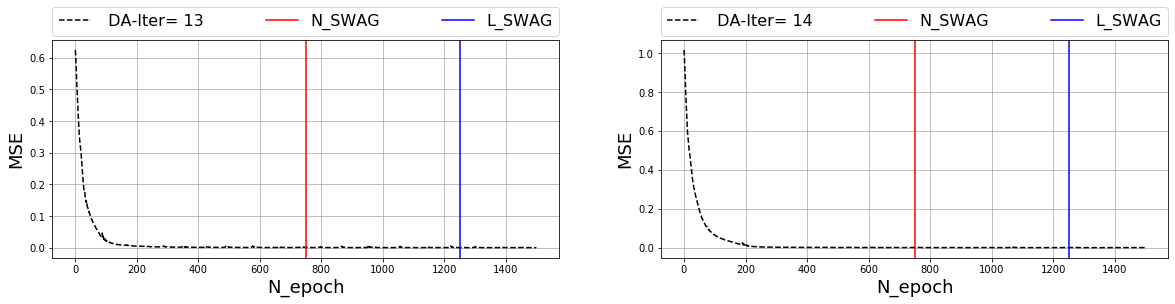

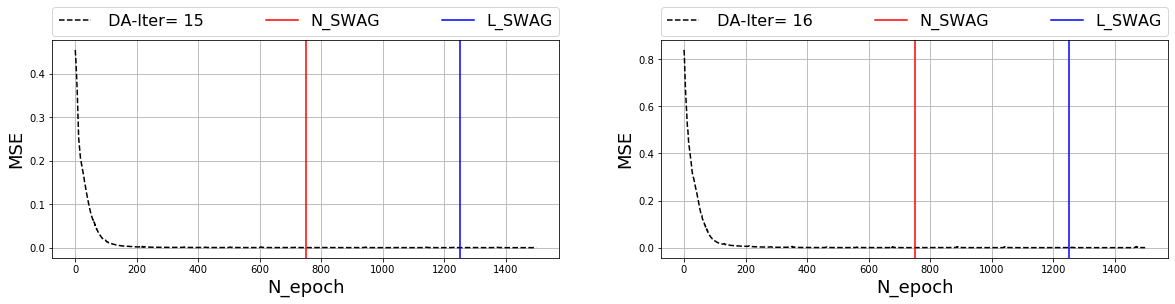

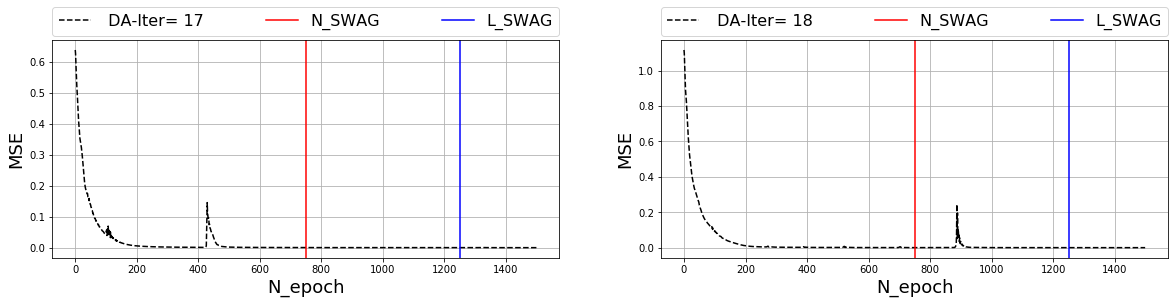

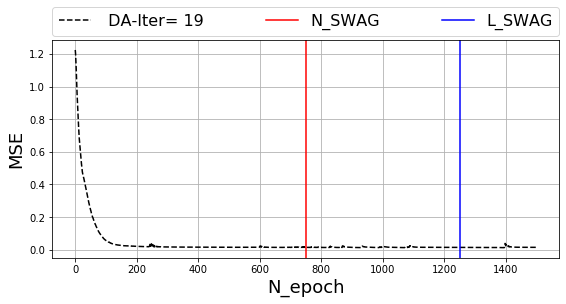

In [13]:
label = "EnVar-DL-SWAG-V2"
PST = PST_dic[label]
print("")
print("----------------- For : " + label+" ------------")
print("")
PST.plot_train_loss(n_col=2)   

## Training data sets 


----------------- For : EnVar-DL ------------



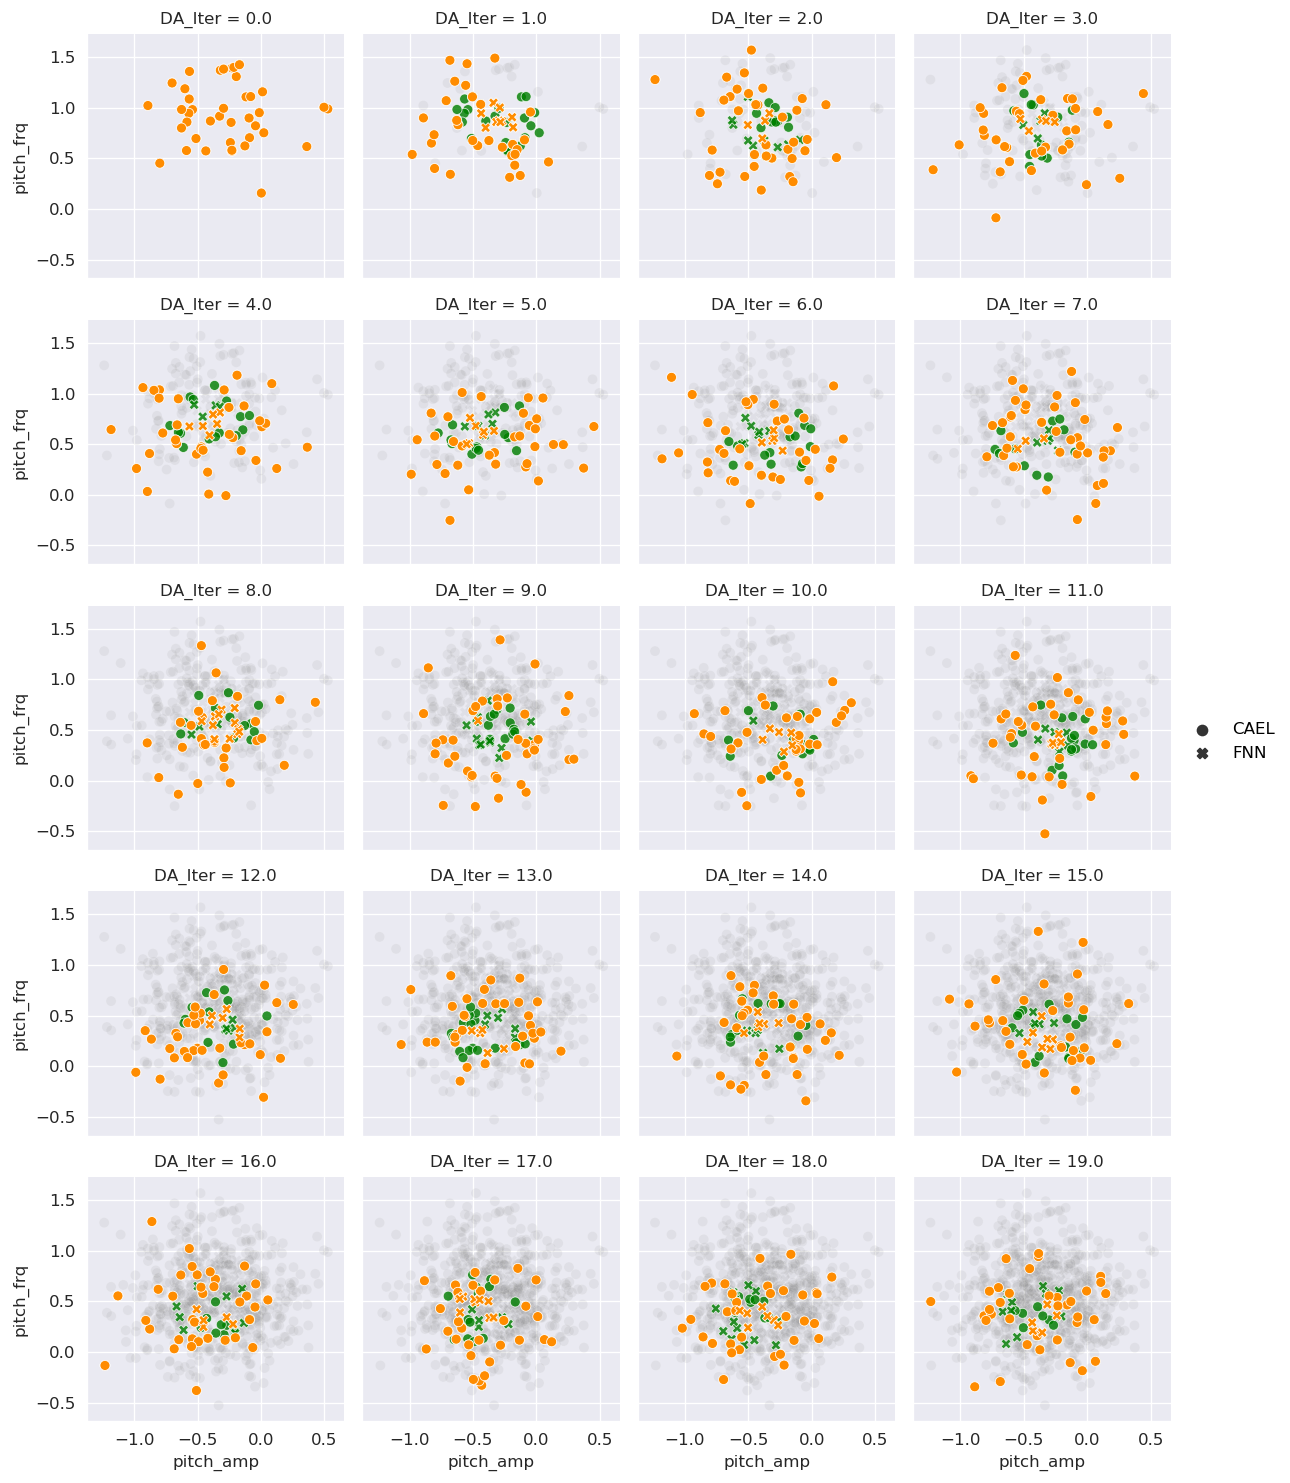

In [14]:
label = "EnVar-DL"
PST = PST_dic[label]
print("")
print("----------------- For : " + label+" ------------")
print("")
All_Data_Set(PST)